# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [4]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [5]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)
from sagemaker.pytorch import PyTorch


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [6]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-10-26 19:44:39--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.117.32
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.117.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip.2’

dogImages.zip.2      17%[==>                 ] 188.06M  46.6MB/s    eta 21s    ^C
Archive:  dogImages.zip
replace dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket
prefix = "sagemaker/pytorch-dogImages"
role = sagemaker.get_execution_role()

In [13]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([16, 32, 64, 128, 256])
}

In [23]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version="py3",
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.c5.18xlarge",
)

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=1,
    objective_type=objective_type,
)

In [ ]:
# TODO: Fit your HP Tuner
input_data='s3://demo-udacity-training123/dogImages'
tuner.fit({
    'data': input_data,
})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [ ]:
# TODO: Get the best estimators and the best HPs
# Return the estimator that has best training job attached.
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-10-27 04:35:33 Starting - Found matching resource for reuse
2022-10-27 04:35:33 Downloading - Downloading input data
2022-10-27 04:35:33 Training - Training image download completed. Training in progress.
2022-10-27 04:35:33 Uploading - Uploading generated training model
2022-10-27 04:35:33 Completed - Resource reused by training job: pytorch-training-221027-0403-003-a1ad0197


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"128"',
 'lr': '0.024204121354093222',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-10-27-04-03-32-667"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-257258815313/pytorch-training-2022-10-27-04-03-32-667/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [26]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import (
    Rule,
    rule_configs,
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [35]:
# TODO: Create and fit an estimator

best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'lr': best_estimator.hyperparameters()['lr']}

estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.c5.18xlarge",
    role=role,
    framework_version="1.6",
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

estimator.fit({'train' : input_data },wait=True)

2022-10-27 07:43:29 Starting - Starting the training job...
2022-10-27 07:43:59 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-10-27 07:45:19 Downloading - Downloading input data...........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-10-27 07:47:06,168 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-10-27 07:47:06,171 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-10-27 07:47:06,180 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-10-27 07:47:06,188 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-10-27 07:47:06,681 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
20

In [36]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-10-27 08:03:43.896 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-257258815313/pytorch-training-2022-10-27-07-43-29-313/debug-output


In [37]:
trial.tensor_names()

[2022-10-27 08:03:46.061 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-10-27 08:03:47.084 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:17 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [42]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    
    plt.show()
    plt.savefig('debugging-output.png')

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


<Figure size 640x480 with 0 Axes>

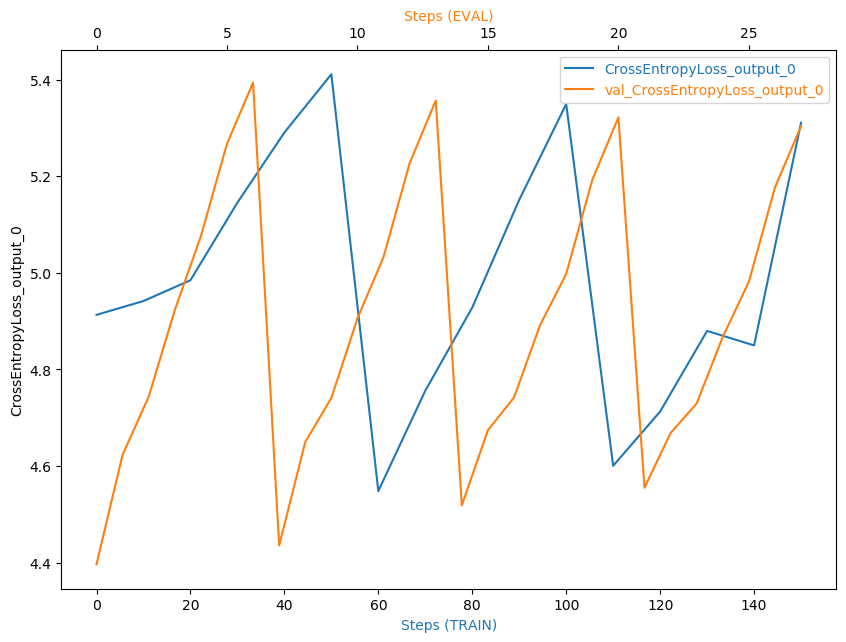

In [46]:
# TODO: Plot a debugging output.
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [47]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"


In [49]:
! aws s3 ls {rule_output_path} --recursive

2022-10-27 08:03:35     374799 pytorch-training-2022-10-27-07-43-29-313/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-10-27 08:03:34     222710 pytorch-training-2022-10-27-07-43-29-313/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-10-27 08:03:29        192 pytorch-training-2022-10-27-07-43-29-313/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-10-27 08:03:29        200 pytorch-training-2022-10-27-07-43-29-313/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-10-27 08:03:29       1970 pytorch-training-2022-10-27-07-43-29-313/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-10-27 08:03:29        127 pytorch-training-2022-10-27-07-43-29-313/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-10-27 08:03:29        199 pytorch-training-2022-10-27-07-43-29-313/rule-output/ProfilerReport/profiler-output/profiler-re

In [50]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-257258815313/pytorch-training-2022-10-27-07-43-29-313/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-257258815313/pytorch-training-2022-10-27-07-43-29-313/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-257258815313/pytorch-training-2022-10-27-07-43-29-313/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-257258815313/pytorch-training-2022-10-27-07-43-29-313/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-257258815313/pytorch-training-2

In [51]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [52]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [55]:
import shutil
shutil.make_archive("./profiler_repot", "zip", "ProfilerReport")

'/root/project3/profiler_repot.zip'

In [61]:
# TODO: Deploy your model to an endpoint
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

model_data_artifacts = "s3://sagemaker-us-east-1-257258815313/pytorch-training-2022-10-27-07-43-29-313/output/model.tar.gz"
inference_path = 'inference.py'
instance_type = 'ml.t2.medium'
endpoint_name = 'AWS-ml-prj3-'+instance_type.replace(".","-")
role = sagemaker.get_execution_role()
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel(
    model_data = model_data_artifacts,
    role = role,
    entry_point= inference_path,
    py_version = "py36",
    framework_version = "1.6",
    predictor_cls = ImgPredictor
)

predictor = pytorch_model.deploy(
    endpoint_name = endpoint_name,
    initial_instance_count = 1,
    instance_type = instance_type
)

---------!

In [ ]:
img_path = "dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg" 

image_class = "24"

with open(img_path , "rb") as f:
    payload = f.read()
    response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
    predicted_class = np.argmax(response,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
    print("predicted class is " + str(predicted_class[0]) + " and the actual class is " + image_class)

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()